# Catboost stack

## Step 0: Importing libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Step 0.1: Preprocessing of data

### Step 1.1: Loading data

In [2]:
PATH_RAW_DATA_LOCATION = "data/raw/"

def get_raw_data():
    """
    Utility function to load the raw data from the data/raw folder.

    Returns:
        train_a (pd.DataFrame): The training targets for the A dataset.
        train_b (pd.DataFrame): The training targets for the B dataset.
        train_c (pd.DataFrame): The training targets for the C dataset.
        X_train_estimated_a (pd.DataFrame): The estimated training features for the A dataset.
        X_train_estimated_b (pd.DataFrame): The estimated training features for the B dataset.
        X_train_estimated_c (pd.DataFrame): The estimated training features for the C dataset.
        X_train_observed_a (pd.DataFrame): The observed training features for the A dataset.
        X_train_observed_b (pd.DataFrame): The observed training features for the B dataset.
        X_train_observed_c (pd.DataFrame): The observed training features for the C dataset.
        X_test_estimated_a (pd.DataFrame): The estimated test features for the A dataset.
        X_test_estimated_b (pd.DataFrame): The estimated test features for the B dataset.
        X_test_estimated_c (pd.DataFrame): The estimated test features for the C dataset.
    """
    train_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/train_targets.parquet')
    train_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/train_targets.parquet')
    train_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/train_targets.parquet')
    X_train_estimated_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_train_estimated.parquet')
    X_train_estimated_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_train_estimated.parquet')
    X_train_estimated_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_train_estimated.parquet')
    X_train_observed_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_train_observed.parquet')
    X_train_observed_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_train_observed.parquet')
    X_train_observed_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_train_observed.parquet')
    X_test_estimated_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_test_estimated.parquet')
    X_test_estimated_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_test_estimated.parquet')
    X_test_estimated_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_test_estimated.parquet')

    return train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c


### Step 1.2: Feature engineering

In [3]:
from datetime import datetime
import pandas as pd
from typing import List, Tuple
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import math


def prepare_data(
    train_observed: pd.DataFrame,
    train_estimated: pd.DataFrame,
    test_size=0.2,
    random_state=42,
    drop_features: bool = True,
) -> Tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.Series,
    pd.Series,
    pd.DataFrame,
    pd.DataFrame,
    pd.Series,
    pd.Series,
]:
    """
    Prepares the data for modeling by handling missing values and splitting the data.

    Args:
    train_observed (pd.DataFrame): The aligned training DataFrame with observed features.
    train_estimated (pd.DataFrame): The aligned training DataFrame with estimated features.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    X_train_obs (pd.DataFrame): The training features with observed data.
    X_val_obs (pd.DataFrame): The validation features with observed data.
    y_train_obs (pd.Series): The training target with observed data.
    y_val_obs (pd.Series): The validation target with observed data.
    X_train_est (pd.DataFrame): The training features with estimated data.
    X_val_est (pd.DataFrame): The validation features with estimated data.
    y_train_est (pd.Series): The training target with estimated data.
    y_val_est (pd.Series): The validation target with estimated data.
    """

    # Remove missing features
    train_observed = remove_missing_features(train_observed)
    train_estimated = remove_missing_features(train_estimated)

    # Handle missing values (e.g., imputation, removal)
    train_observed_clean = train_observed.dropna(
        subset=["visibility:m", "pv_measurement"]
    )
    train_estimated_clean = train_estimated.dropna(
        subset=["visibility:m", "pv_measurement"]
    )

    # Remove discrepancies
    train_observed_clean = remove_discrepancies(train_observed_clean)
    train_estimated_clean = remove_discrepancies(train_estimated_clean)

    # Feature engineer
    train_observed_clean = feature_engineer(train_observed_clean)
    train_estimated_clean = feature_engineer(train_estimated_clean)

    # Split the data into features (X) and target (y)

    y_obs = train_observed_clean["pv_measurement"]

    if drop_features:
        X_obs = train_observed_clean.drop(
            columns=["time", "pv_measurement", "date_forecast", "date_calc"],
            errors="ignore",
        )
    else:
        X_obs = train_observed_clean

    if drop_features:
        X_est = train_estimated_clean.drop(
            columns=["time", "pv_measurement", "date_calc", "date_forecast"],
            errors="ignore",
        )
    else:
        X_est = train_estimated_clean

    y_est = train_estimated_clean["pv_measurement"]

    # Split the data into training and validation sets
    X_train_obs, X_val_obs, y_train_obs, y_val_obs = train_test_split(
        X_obs, y_obs, test_size=test_size, random_state=random_state
    )
    X_train_est, X_val_est, y_train_est, y_val_est = train_test_split(
        X_est, y_est, test_size=test_size, random_state=random_state
    )

    return (
        X_train_obs,
        X_val_obs,
        y_train_obs,
        y_val_obs,
        X_train_est,
        X_val_est,
        y_train_est,
        y_val_est,
    )


def get_location_datasets(
    df: pd.DataFrame,
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    locations = ["location_a", "location_b", "location_c"]
    x_a = df[df["location_a"] == 1]
    x_a = x_a.drop(locations, axis=1)
    y_a = x_a["pv_measurement"]
    if "pv_measurement" in x_a.columns:
        x_a = x_a.drop("pv_measurement", axis=1)

    x_b = df[df["location_b"] == 1]
    x_b = x_b.drop(locations, axis=1)
    y_b = x_b["pv_measurement"]
    if "pv_measurement" in x_b.columns:
        x_b = x_b.drop("pv_measurement", axis=1)

    x_c = df[df["location_c"] == 1]
    x_c = x_c.drop(locations, axis=1)
    y_c = x_c["pv_measurement"]
    if "pv_measurement" in x_b.columns:
        x_b = x_b.drop("pv_measurement", axis=1)

    return (x_a, x_b, x_c, y_a, y_b, y_c)


def remove_missing_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop("snow_density:kgm3", axis=1)
    df = df.drop("ceiling_height_agl:m", axis=1)
    df["cloud_base_agl:m"] = df["cloud_base_agl:m"].fillna(0)
    df = df.drop("elevation:m", axis=1)
    return df


def remove_discrepancies(df: pd.DataFrame) -> pd.DataFrame:
    df = remove_positive_pv_in_night(df)
    df = remove_night_light_discrepancies(df)
    df = remove_zero_value_discrepancies(df)
    df = remove_faulty_zero_measurements_for_direct_sun_light(df)
    # df = remove_outliers(df)
    return df


def remove_positive_pv_in_night(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove positive pv measurements when is_day is 0 and pv_measurement is positive and pv_measurement is the same next timestep
    """
    # Remove positive pv measurements when is_day is 0 and pv_measurement is positive and pv_measurement is the same next timestep
    df = df.drop(
        df[
            (df["is_day:idx"] == 0)
            & (df["pv_measurement"] > 0)
            & (df["pv_measurement"] == df["pv_measurement"].shift(1))
        ].index
    )

    # Remove positive pv measurements when sun_elevation is negative
    threshold = -10
    df = df.drop(
        df[(df["sun_elevation:d"] < threshold) & (df["pv_measurement"] > 0)].index
    )
    return df


def remove_outliers(
    df: pd.DataFrame, lower_bound: float = 0.1, upper_bound: float = 0.9
) -> pd.DataFrame:
    """
    Removing outliers using IQR method
    """

    columns_to_check = [col for col in df.columns if col != "pv_measurement"]
    for col in columns_to_check:
        # Calculate IQR
        Q1 = df[col].quantile(lower_bound)
        Q3 = df[col].quantile(upper_bound)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the data
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df


def remove_night_light_discrepancies(df: pd.DataFrame) -> pd.DataFrame:
    # Remove all rows where pv_measurement has the same value for 6 timesteps and not is 0 remove them

    # Step 1: Identify runs of equal, non-zero values
    df["group"] = (
        (df["pv_measurement"] != df["pv_measurement"].shift())
        | (df["pv_measurement"] == 0)
    ).cumsum()

    # Step 2: Count occurrences in each run
    counts = df.groupby("group")["pv_measurement"].transform("count")

    # Step 3: Identify groups to remove
    to_remove = (counts >= 6) & (df["pv_measurement"] != 0)

    # Step 4: Remove those rows
    df_cleaned = df[~to_remove].drop(columns=["group"])
    return df_cleaned


def remove_zero_value_discrepancies(df: pd.DataFrame) -> pd.DataFrame:
    # Remove all rows where pv_measurement has the same value for 100 timesteps and is 0 remove them

    # Didn't do anything lol

    # Step 1: Identify runs of equal, non-zero values
    return df



def remove_faulty_zero_measurements_for_direct_sun_light(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """ """
    mask = ((df["diffuse_rad:W"] + df["direct_rad:W"]) >= 30) & (
        df["pv_measurement"] == 0
    )
    df = df[~mask]
    return df


def feature_engineer(data_frame: pd.DataFrame) -> pd.DataFrame:
    data_frame = create_time_features_from_date(data_frame)
    # data_frame = create_expected_pv_based_on_previous_years_same_day(data_frame)
    data_frame["sun_product"] = data_frame["diffuse_rad:W"] * data_frame["direct_rad:W"]

    data_frame["modified_solar_elevation"] = np.where(
        data_frame["sun_elevation:d"] <= 0,
        0,
        np.sin(np.radians(data_frame["sun_elevation:d"])),
    )
    data_frame = data_frame.drop("sun_elevation:d", axis=1)

    data_frame["effective_radiation"] = np.where(
        data_frame["clear_sky_energy_1h:J"] == 0,
        0,  # or your specified value
        data_frame["direct_rad_1h:J"] / data_frame["clear_sky_energy_1h:J"],
    )

    # # Check for the existence of date_calc column
    # if "date_calc" not in data_frame.columns:
    #     data_frame["time_since_prediction"] = 0
    # else:
    #     data_frame["time_since_prediction"] = 1

    # data_frame["time_since_prediction"] =

    data_frame["residual_radiation"] = (
        data_frame["clear_sky_rad:W"]
        - data_frame["direct_rad:W"]
        - data_frame["diffuse_rad:W"]
    )

    # WAS WORSE
    # data_frame["effective_radiation2"] = np.where(
    #     data_frame["clear_sky_rad:W"] == 0,
    #     0,  # or your specified value
    #     data_frame["direct_rad:W"] / data_frame["clear_sky_rad:W"],
    # )

    data_frame["cloud_ratio"] = np.where(
        data_frame["total_cloud_cover:p"] == 0,
        0,  # or your specified value
        data_frame["effective_cloud_cover:p"] / data_frame["total_cloud_cover:p"],
    )

    data_frame["diffuse_cloud_conditional_interaction"] = data_frame[
        "diffuse_rad:W"
    ].where(data_frame["effective_cloud_cover:p"] < 0.3, 0)

    data_frame["cloud_cover_over_30%"] = np.where(
        data_frame["effective_cloud_cover:p"] > 30, 1, 0
    )

    data_frame["sun_addition"] = (
        data_frame["diffuse_rad:W"] + data_frame["direct_rad:W"]
    )

    data_frame["direct_rad_cloud_interaction"] = data_frame["direct_rad:W"] * (
        100 - data_frame["effective_cloud_cover:p"]
    )

    data_frame["modified_solar_elevation_squared"] = (
        data_frame["modified_solar_elevation"] ** 0.5
    )
    
    # data_frame["sun_addition_squared"] = data_frame["sun_addition"] ** 2

    snow_columns = [
        "snow_depth:cm",
        "fresh_snow_12h:cm",
        "fresh_snow_1h:cm",
        "fresh_snow_24h:cm",
        "fresh_snow_3h:cm",
        "fresh_snow_6h:cm",
    ]

    data_frame["is_freezing"] = (data_frame["t_1000hPa:K"] < 273).astype(int)

    data_frame["is_snow"] = (data_frame[snow_columns] > 0).any(axis=1).astype(int)
    data_frame["is_rain"] = (data_frame["precip_5min:mm"] > 0).astype(int)

    data_frame = data_frame.drop("snow_drift:idx", axis=1)

    return data_frame


def ratio(df: pd.DataFrame) -> pd.DataFrame:
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    # Sample DataFrame (replace this with your actual DataFrame)

    # Calculate total irradiance
    df["total_radiance"] = df["direct_radiance"] + df["diffuse_radiance"]

    # Set up the linear regression problem
    X = df[["total_radiance", "ambient_temp"]]
    y = df["pv_measurement"]

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Extract coefficients
    a = model.coef_[0]  # Coefficient for total_radiance
    b = model.coef_[1]  # Coefficient for ambient_temp
    c = model.intercept_

    # Estimate the parameters
    T_ref = 25  # Reference temperature, you can set this based on your understanding
    eta = a  # Assuming that a corresponds to efficiency
    beta = (
        -b / a
    )  # Assuming linear relationship between power drop and temperature increase

    # Estimate panel temperature
    df["T_panel"] = df["ambient_temp"] + (df["total_radiance"] / a) * (1 - eta)

    # Calculate the desired ratio
    df["ratio"] = 1 - beta * (df["T_panel"] - T_ref)

    # Display the DataFrame
    return df


def calculate_surface_temp(row):
    # Constants
    R = 287  # Specific gas constant for dry air, J kg^-1 K^-1
    g = 9.81  # Acceleration due to gravity, m s^-2
    lapse_rate = 0.0065  # Average lapse rate, K m^-1

    P1 = 1000  # Initial pressure level, hPa
    P2 = row["sfc_pressure:hPa"]  # Final pressure level, hPa
    T1 = row["t_1000hPa:K"]  # Temperature at P1, K

    # Altitude difference using barometric formula (approximation)
    delta_h = (R * T1 / g) * np.log(P1 / P2)

    # Temperature difference using constant lapse rate
    delta_T = lapse_rate * delta_h

    # Temperature at P2, converting from K to C
    T2_C = T1 - delta_T - 273.15

    return T2_C




def create_time_features_from_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new data frame with new features from date_forecast column.
    This will create temporal features from date_forecast that are easier to learn by the model.
    It creates the following features: month, season, year, day_of_year, day_segment.
    All of the new features are int type.

    Args:
        df (pd.DataFrame): Data frame with date_forecast column.
    Returns:
        pd.DataFrame: Data frame copy with new features.

    """
    # df["days_from_peak"] = df["date_forecast"].apply(nearest_june_21st)
    df["sin_day_of_year"] = df["date_forecast"].apply(get_sin_day)
    df["cos_day_of_year"] = df["date_forecast"].apply(get_cos_day)
    df["sin_hour"] = df["date_forecast"].apply(get_sin_hour)
    df["cos_hour"] = df["date_forecast"].apply(get_cos_hour)
    return df


def nearest_june_21st(date):
    from datetime import datetime, timedelta

    # Find June 21st of the same year and the next year
    this_year = datetime(date.year, 6, 21)
    next_year = datetime(date.year + 1, 6, 21)
    last_year = datetime(date.year - 1, 6, 21)

    # Calculate the absolute difference in days
    days_this_year = abs((date - this_year).days)
    days_next_year = abs((date - next_year).days)
    days_last_year = abs((date - last_year).days)

    # Return the smallest difference
    return min(days_this_year, days_next_year, days_last_year)


def get_sin_hour(date: datetime) -> float:
    HOURS_OF_DAY = 24
    return math.sin(2 * math.pi * (date.hour) / HOURS_OF_DAY)


def get_cos_hour(date: datetime) -> float:
    HOURS_OF_DAY = 24
    return math.cos(2 * math.pi * (date.hour) / HOURS_OF_DAY)


def get_sin_day(date: datetime) -> float:
    DAY_OF_YEAR = 365.25  # Add 0.25 to account for leap years
    return math.sin(2 * math.pi * (date.timetuple().tm_yday - 1) / DAY_OF_YEAR)


def get_cos_day(date: datetime) -> float:
    DAY_OF_YEAR = 365.25  # Add 0.25 to account for leap years
    return math.cos(2 * math.pi * (date.timetuple().tm_yday - 1) / DAY_OF_YEAR)


def create_polynomial_features(
    df, columns, degree=2, include_bias=False, interaction_only=False
):
    """
    Create polynomial features for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names for which to create polynomial features.
    - degree (int): The degree of the polynomial features. Default is 2.
    - include_bias (bool): Whether to include a bias column in the output. Default is False.
    - interaction_only (bool): Whether to include only interaction features. Default is False.

    Returns:
    - df_poly (pd.DataFrame): DataFrame with original and new polynomial features.
    """
    poly = PolynomialFeatures(
        degree=degree, include_bias=include_bias, interaction_only=interaction_only
    )
    poly_features = poly.fit_transform(df[columns])
    feature_names = poly.get_feature_names(input_features=columns)

    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    df_poly = df_poly.drop(
        columns=columns
    )  # Drop original columns as they are included in the polynomial features

    # Concatenate the original DataFrame with the new polynomial features DataFrame
    df_poly = pd.concat([df.drop(columns=columns), df_poly], axis=1)

    return df_poly


def log_transform(df: pd.DataFrame, columns: List[str]):
    df_transformed = df.copy()
    for column in columns:
        df_transformed[column] = np.log1p(df_transformed[column])
    return df_transformed


def scale_features(df: pd.DataFrame, columns: List[str], method="standard"):
    df_scaled = df.copy()
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    return df_scaled


def trig_transform(df: pd.DataFrame, column: str, period: int):
    df_trig = df.copy()
    df_trig[f"{column}_sin"] = np.sin(2 * math.pi * df_trig[column] / period)
    df_trig[f"{column}_cos"] = np.cos(2 * math.pi * df_trig[column] / period)
    return df_trig


def create_expected_pv_based_on_previous_years_same_day(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Create a mean pv_measurement for each data point based on the previous years same day and hour
    Add this as a feature to the data frame

    Parameters:
        df (pd.DataFrame): DataFrame containing at least columns:
                           location_a, location_b, location_c, date_forecast,
                           pv_measurement, sin_day_of_year, cos_day_of_year, sin_hour, cos_hour

    Returns:
        pd.DataFrame: DataFrame with additional feature of mean pv_measurement based on historical data
    """
    df = df.copy()
    # When the data does not contain needed columns, return the original df.
    if not all(
        col in df.columns
        for col in [
            "location_a",
            "location_b",
            "location_c",
            "pv_measurement",
            "sin_day_of_year",
            "cos_day_of_year",
            "sin_hour",
            "cos_hour",
        ]
    ):
        return df
    # Identify the location from the binary flags
    df["location"] = df[["location_a", "location_b", "location_c"]].idxmax(axis=1)

    # Calculate mean pv_measurement for each location, sin_day_of_year, cos_day_of_year, sin_hour, and cos_hour
    mean_pv = (
        df.groupby(
            ["location", "sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]
        )["pv_measurement"]
        .mean()
        .reset_index()
    )
    mean_pv.rename(columns={"pv_measurement": "mean_pv_measurement"}, inplace=True)

    # Merge mean_pv_measurement back to the original DataFrame
    df = pd.merge(
        df,
        mean_pv,
        on=["location", "sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"],
        how="left",
    )
    df.drop(columns=["location"], inplace=True)
    return df


def create_simple_rolling_mean(
    df: pd.DataFrame, column: str, window: int
) -> pd.DataFrame:
    """
    Creates a simple rolling mean feature for a given column in a DataFrame.

    Args:
        df: DataFrame containing your time-series data.
        column: The name of the column for which you want to create lagged features.
        window: The size of the window for calculating the rolling mean.
                For example, if window=10, it will take the previous 10 days.
    """
    # Ensure the DataFrame is sorted by date
    df = df.sort_values(by="date_forecast")

    # Ensure 'date_forecast' is in datetime format
    df["date_forecast"] = pd.to_datetime(df["date_forecast"])

    # Calculate the rolling mean
    df["rolling_mean_of_" + column] = df[column].rolling(window=window).mean()

    return df


# Define a function to identify positively skewed numerical features in a DataFrame
def identify_skewed_features(df, skew_threshold=1):
    # Select numerical features
    num_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

    # Calculate skewness for each numerical feature and filter those that are positively skewed
    skewed_features = [
        feature for feature in num_features if skew(df[feature]) > skew_threshold
    ]

    return skewed_features


def create_domain_specific_features(df):
    """
    Create domain-specific features for solar energy production.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - df_domain (pd.DataFrame): DataFrame with original and new domain-specific features.
    """
    df_domain = df.copy()

    # Create a binary feature representing whether the sky is clear
    df_domain["is_clear_sky"] = (df_domain["clear_sky_energy_1h:J"] > 0).astype(int)

    # Create a feature representing total sun exposure
    df_domain["total_sun_exposure"] = (
        df_domain["direct_rad:W"] + df_domain["diffuse_rad:W"]
    )

    # Create a binary feature representing whether it is raining
    df_domain["is_raining"] = (df_domain["precip_5min:mm"] > 0).astype(int)

    # Create a binary feature representing whether there is snow cover
    df_domain["is_snow_cover"] = (df_domain["snow_depth:cm"] > 0).astype(int)

    return df_domain


def clean_data(data_frame: pd.DataFrame) -> pd.DataFrame:
    """
    Clean data frame by removing outliers and NaN values.

    Args:
        df (pd.DataFrame): Data frame with date_forecast column.
    Returns:
        pd.DataFrame: Data frame copy without outliers and NaN values.

    """
    df = data_frame.copy()
    df = create_time_features_from_date(df)
    df = df[df["target"] > 0]
    return df


def add_location(data_frame: pd.DataFrame, location: str):
    if location.lower() == "a":
        data_frame["location_a"] = 1
    else:
        data_frame["location_a"] = 0

    if location.lower() == "b":
        data_frame["location_b"] = 1
    else:
        data_frame["location_b"] = 0

    if location.lower() == "c":
        data_frame["location_c"] = 1
    else:
        data_frame["location_c"] = 0
    return data_frame


# Define a function to align the temporal resolution of the datasets
def temporal_alignment(
    train: pd.DataFrame, observed: pd.DataFrame, estimated: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Aligns the temporal resolution of the datasets by aggregating the 15-min interval weather data to hourly intervals.

    Args:
        train (pd.DataFrame): The training targets DataFrame.
        observed (pd.DataFrame): The observed training features DataFrame.
        estimated (pd.DataFrame): The estimated training features DataFrame.

    Returns:
        train_observed (pd.DataFrame): The aligned training DataFrame with observed features.
        train_estimated (pd.DataFrame): The aligned training DataFrame with estimated features.
    """
    # Convert the time columns to datetime objects
    train["time"] = pd.to_datetime(train["time"])
    observed["date_forecast"] = pd.to_datetime(observed["date_forecast"])
    estimated["date_forecast"] = pd.to_datetime(estimated["date_forecast"])

    # Set the date_forecast column as index for resampling
    observed.set_index("date_forecast", inplace=True)
    estimated.set_index("date_forecast", inplace=True)

    # Resample the weather data to hourly intervals and aggregate the values by mean
    observed_resampled = observed.resample("1H").mean()
    estimated_resampled = estimated.resample("1H").mean()

    # Reset the index after resampling
    observed_resampled.reset_index(inplace=True)
    estimated_resampled.reset_index(inplace=True)

    # Merge the aggregated weather data with the solar production data based on the timestamp
    train_observed = pd.merge(
        train, observed_resampled, how="left", left_on="time", right_on="date_forecast"
    )
    train_estimated = pd.merge(
        train, estimated_resampled, how="left", left_on="time", right_on="date_forecast"
    )

    return train_observed, train_estimated


def temporal_alignment_tests(test: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return aggregate_rows(test)


def aggregate_rows(df: pd.DataFrame) -> pd.DataFrame:
    # Create a 'group' column to group every 4 rows together
    df["group"] = df.index // 4

    # Define the aggregation functions
    aggregation = {col: "mean" for col in df.columns if col != "date_forecast"}
    aggregation["date_forecast"] = "first"

    # Group by the 'group' column and aggregate
    df_agg = df.groupby("group").agg(aggregation).reset_index(drop=True)

    # Drop the 'group' column from the original dataframe
    df_agg.drop("group", axis=1, inplace=True)

    return df_agg


In [4]:
from typing import Tuple
import pandas as pd

def fetch_preprocessed_data(drop_features: bool = True) -> (
    Tuple[
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
    ]
):
    """
    Fetch the preprocessed data for training and validation.

    Returns:
        X_train_obs_combined: The observed data for training
        X_val_obs_combined: The observed data for validation
        y_train_obs_combined: The observed labels for training
        y_val_obs_combined: The observed labels for validation
        X_train_est_combined: The estimated data for training
        X_val_est_combined: The estimated data for validation
        y_train_est_combined: The estimated labels for training
        y_val_est_combined: The estimated labels for validation
    """
    (
        train_a,
        train_b,
        train_c,
        X_train_estimated_a,
        X_train_estimated_b,
        X_train_estimated_c,
        X_train_observed_a,
        X_train_observed_b,
        X_train_observed_c,
        _,
        _,
        _,
    ) = get_raw_data()

    # Temporally align the data from all three locations to the same time.
    train_observed_a, train_estimated_a = temporal_alignment(
        train_a, X_train_observed_a, X_train_estimated_a
    )
    train_observed_b, train_estimated_b = temporal_alignment(
        train_b, X_train_observed_b, X_train_estimated_b
    )
    train_observed_c, train_estimated_c = temporal_alignment(
        train_c, X_train_observed_c, X_train_estimated_c
    )

    # Add location data
    train_observed_a = add_location(train_observed_a, "a")
    train_estimated_a = add_location(train_estimated_a, "a")

    train_observed_b = add_location(train_observed_b, "b")
    train_estimated_b = add_location(train_estimated_b, "b")

    train_observed_c = add_location(train_observed_c, "c")
    train_estimated_c = add_location(train_estimated_c, "c")

    # Combine the temporally aligned datasets from all three locations
    train_observed_combined = pd.concat(
        [train_observed_a, train_observed_b, train_observed_c], ignore_index=True
    )
    train_estimated_combined = pd.concat(
        [train_estimated_a, train_estimated_b, train_estimated_c], ignore_index=True
    )


    # # Add boolean flag for estimated vs observed
    # train_observed_combined["estimated_flag"] = 0
    # train_estimated_combined["estimated_flag"] = 1

    # Prepare the combined dataset by handling missing values and splitting the data
    (
        X_train_obs_combined,
        X_val_obs_combined,
        y_train_obs_combined,
        y_val_obs_combined,
        X_train_est_combined,
        X_val_est_combined,
        y_train_est_combined,
        y_val_est_combined,
    ) = prepare_data(train_observed_combined, train_estimated_combined, drop_features=drop_features)

    return (
        X_train_obs_combined,
        X_val_obs_combined,
        y_train_obs_combined,
        y_val_obs_combined,
        X_train_est_combined,
        X_val_est_combined,
        y_train_est_combined,
        y_val_est_combined,
    )

def get_preprocessed_test_data() -> pd.DataFrame:
    """
    Get the preprocessed test data without the 'date_forecast' column.
    """
    (
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        X_test_estimated_a,
        X_test_estimated_b,
        X_test_estimated_c,
    ) = get_raw_data()

    # Align the test data to the same time as the training data
    X_test_estimated_a = temporal_alignment_tests(X_test_estimated_a)
    X_test_estimated_b = temporal_alignment_tests(X_test_estimated_b)
    X_test_estimated_c = temporal_alignment_tests(X_test_estimated_c)
    print("After temporal alignment")
    print(f"X_test_estimated_a.shape = {X_test_estimated_a.shape}, X_test_estimated_b.shape = {X_test_estimated_b.shape}, X_test_estimated_c.shape = {X_test_estimated_c.shape}")

    X_test_estimated_a = remove_missing_features(X_test_estimated_a)
    X_test_estimated_b = remove_missing_features(X_test_estimated_b)
    X_test_estimated_c = remove_missing_features(X_test_estimated_c)

    # Add location data
    X_test_estimated_a = add_location(X_test_estimated_a, "a")
    X_test_estimated_b = add_location(X_test_estimated_b, "b")
    X_test_estimated_c = add_location(X_test_estimated_c, "c")

    X_test_a_correct_features = feature_engineer(X_test_estimated_a)
    X_test_b_correct_features = feature_engineer(X_test_estimated_b)
    X_test_c_correct_features = feature_engineer(X_test_estimated_c)

    # X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
    
    # # Add historical data so that the model can use it for prediction
    # # Add mean_pv_measurement with same day and hour from previous years
    # X_test_estimated_a_with_historical_data = add_expected_pv_to_test_data(X_test_a_correct_features, X_train_obs_combined)
    # X_test_estimated_b_with_historical_data = add_expected_pv_to_test_data(X_test_b_correct_features, X_train_obs_combined)
    # X_test_estimated_c_with_historical_data = add_expected_pv_to_test_data(X_test_c_correct_features, X_train_obs_combined)

    # Drop the 'date_calc' and 'date_forecast' columns from the test data
    X_test_estimated_a_processed = X_test_a_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )
    X_test_estimated_b_processed = X_test_b_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )
    X_test_estimated_c_processed = X_test_c_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )

    # # # Handle NaN values in the test data by filling them with the mean value of the respective column from the training data
    # X_test_estimated_a_processed.dropna()
    # X_test_estimated_b_processed.dropna()
    # X_test_estimated_c_processed.dropna()
    print(f"X_test_estimated_a_processed.shape = {X_test_estimated_a_processed.shape}, X_test_estimated_b_processed.shape = {X_test_estimated_b_processed.shape}, X_test_estimated_c_processed.shape = {X_test_estimated_c_processed.shape}")
    tests = pd.concat([X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed], ignore_index=True)

    # Add boolean flag for estimated vs observed data
    # tests["estimated_flag"] = 1
    return tests


## Step 1: Loading data

In [5]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

#estimated_flag
X_train_obs_combined["estimated_flag"] = 0
X_val_obs_combined["estimated_flag"] = 0
X_train_est_combined["estimated_flag"] = 1
X_val_est_combined["estimated_flag"] = 1
x_test_whole["estimated_flag"] = 1


x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 60), X_test_estimated_b_processed.shape = (720, 60), X_test_estimated_c_processed.shape = (720, 60)


In [6]:
x_whole["pv_measurement"] = y_whole
df_shuffled = x_whole.sample(frac=1, random_state=42).reset_index(drop=True)
x_whole_a = df_shuffled[df_shuffled['location_a'] == 1]
x_whole_b = df_shuffled[df_shuffled['location_b'] == 1]
x_whole_c = df_shuffled[df_shuffled['location_c'] == 1]

y_whole_a = x_whole_a["pv_measurement"]
x_whole_a = x_whole_a.drop("pv_measurement", axis = 1)
x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

y_whole_b = x_whole_b["pv_measurement"]
x_whole_b = x_whole_b.drop("pv_measurement", axis = 1)
x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

y_whole_c = x_whole_c["pv_measurement"]
x_whole_c = x_whole_c.drop("pv_measurement", axis = 1)
x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)
cat_features = ["estimated_flag"]

Training

In [7]:
best_model_a = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function="MAE",
    verbose = 100
)
best_model_a.fit(x_whole_a, y_whole_a)

0:	learn: 615.2289223	total: 230ms	remaining: 3m 50s
100:	learn: 201.4072982	total: 4.33s	remaining: 38.6s
200:	learn: 186.0497580	total: 8.37s	remaining: 33.3s
300:	learn: 181.1303390	total: 12.5s	remaining: 29s
400:	learn: 177.2485579	total: 16.5s	remaining: 24.7s
500:	learn: 172.6623044	total: 20.6s	remaining: 20.5s
600:	learn: 163.7204714	total: 24.7s	remaining: 16.4s
700:	learn: 154.4498268	total: 28.9s	remaining: 12.3s
800:	learn: 146.6204772	total: 33.3s	remaining: 8.28s
900:	learn: 139.9470005	total: 37.5s	remaining: 4.12s
999:	learn: 134.5556506	total: 41.5s	remaining: 0us


In [8]:
best_model_b = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function="MAE",
    verbose = 100
)
best_model_b.fit(x_whole_b, y_whole_b)

0:	learn: 94.2791670	total: 63.8ms	remaining: 1m 3s
100:	learn: 25.1394341	total: 4.41s	remaining: 39.3s
200:	learn: 21.7299397	total: 8.85s	remaining: 35.2s
300:	learn: 20.2992389	total: 13s	remaining: 30.3s
400:	learn: 19.0627633	total: 17.1s	remaining: 25.5s
500:	learn: 17.9527669	total: 21s	remaining: 21s
600:	learn: 17.1682651	total: 25s	remaining: 16.6s
700:	learn: 16.6932226	total: 29.4s	remaining: 12.5s
800:	learn: 15.8845163	total: 33.9s	remaining: 8.42s
900:	learn: 15.3506132	total: 38.4s	remaining: 4.22s
999:	learn: 14.9515366	total: 42.6s	remaining: 0us


In [9]:
best_model_c = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function = "MAE",
    verbose = 100
)
best_model_c.fit(x_whole_c, y_whole_c)

0:	learn: 78.8208115	total: 22.3ms	remaining: 22.3s
100:	learn: 21.4396391	total: 4.13s	remaining: 36.8s
200:	learn: 18.5151414	total: 8.16s	remaining: 32.5s
300:	learn: 17.0987782	total: 12.2s	remaining: 28.3s
400:	learn: 16.0406782	total: 16.2s	remaining: 24.1s
500:	learn: 15.0533016	total: 20.1s	remaining: 20s
600:	learn: 14.2314945	total: 24.1s	remaining: 16s
700:	learn: 13.6329705	total: 28s	remaining: 12s
800:	learn: 13.1507093	total: 32.1s	remaining: 7.97s
900:	learn: 12.7614489	total: 36.1s	remaining: 3.96s
999:	learn: 12.4840959	total: 39.9s	remaining: 0us


## Visualizing predictions

                                  Feature    Importance
0                absolute_humidity_2m:gm3  1.043385e+00
1                     air_density_2m:kgm3  9.419058e-01
2                   clear_sky_energy_1h:J  3.456527e+00
3                         clear_sky_rad:W  5.488244e+00
4                        cloud_base_agl:m  1.652099e+00
5                         dew_or_rime:idx  9.477881e-04
6                          dew_point_2m:K  9.605845e-01
7                           diffuse_rad:W  1.012781e+00
8                        diffuse_rad_1h:J  1.598362e+00
9                            direct_rad:W  2.769480e+00
10                        direct_rad_1h:J  4.093084e+00
11                effective_cloud_cover:p  2.927910e+00
12                      fresh_snow_12h:cm  1.107744e-01
13                       fresh_snow_1h:cm  6.839708e-04
14                      fresh_snow_24h:cm  1.554163e-01
15                       fresh_snow_3h:cm  5.249190e-03
16                       fresh_snow_6h:cm  8.414

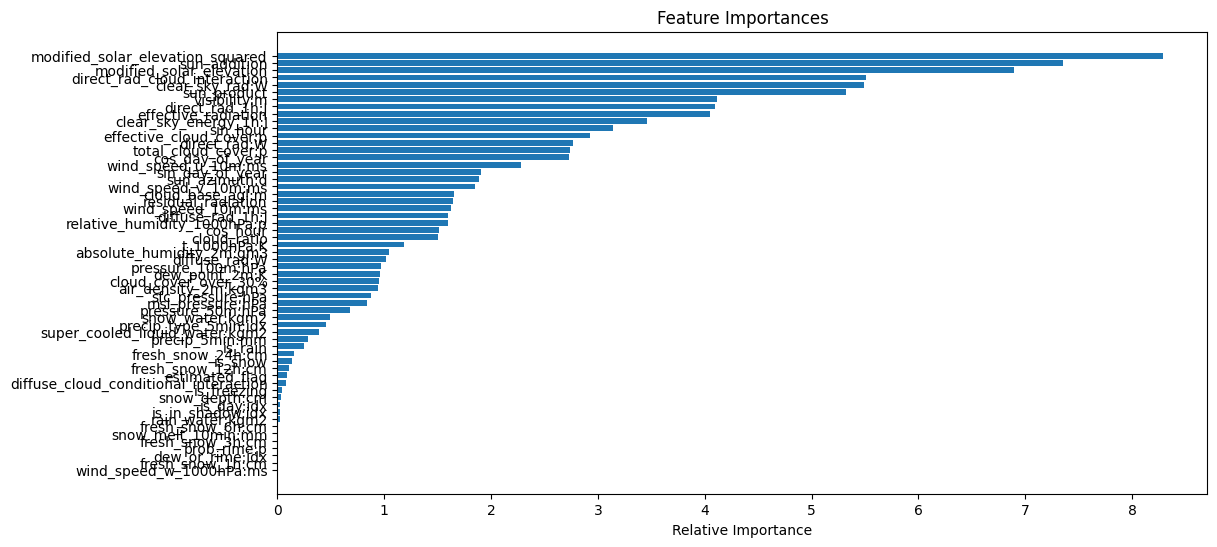

In [10]:
feature_importances = best_model_a.get_feature_importance()

# Get feature names
feature_names = x_whole_a.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# Display the feature importances
print(feature_importance_df)
# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

                                  Feature  Importance
3                         clear_sky_rad:W    8.342514
51                           sun_addition    6.464792
52           direct_rad_cloud_interaction    5.788001
45               modified_solar_elevation    5.689751
2                   clear_sky_energy_1h:J    5.195506
53       modified_solar_elevation_squared    5.138716
9                            direct_rad:W    4.602944
10                        direct_rad_1h:J    3.738508
7                           diffuse_rad:W    2.992828
4                        cloud_base_agl:m    2.897422
42                               sin_hour    2.870614
47                     residual_radiation    2.752399
44                            sun_product    2.721378
40                        sin_day_of_year    2.694257
46                    effective_radiation    2.662344
41                        cos_day_of_year    2.661469
33                            t_1000hPa:K    2.352271
11                effective_

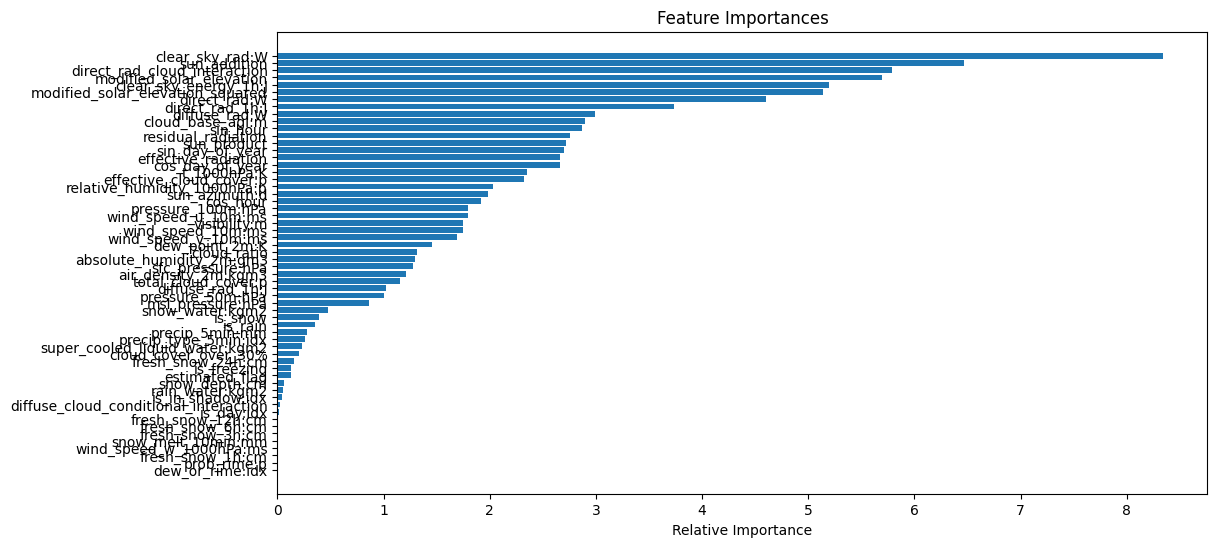

In [11]:
feature_importances = best_model_b.get_feature_importance()

# Get feature names
feature_names = x_whole_b.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

                                  Feature  Importance
45               modified_solar_elevation    9.167129
9                            direct_rad:W    7.843248
3                         clear_sky_rad:W    7.642986
10                        direct_rad_1h:J    5.803242
2                   clear_sky_energy_1h:J    5.304783
44                            sun_product    4.286788
53       modified_solar_elevation_squared    4.247043
52           direct_rad_cloud_interaction    3.947823
51                           sun_addition    3.794217
33                            t_1000hPa:K    3.571950
26            relative_humidity_1000hPa:p    3.160275
46                    effective_radiation    2.515356
47                     residual_radiation    2.487088
40                        sin_day_of_year    2.237831
41                        cos_day_of_year    2.114798
38                    wind_speed_v_10m:ms    2.076690
37                    wind_speed_u_10m:ms    2.048721
11                effective_

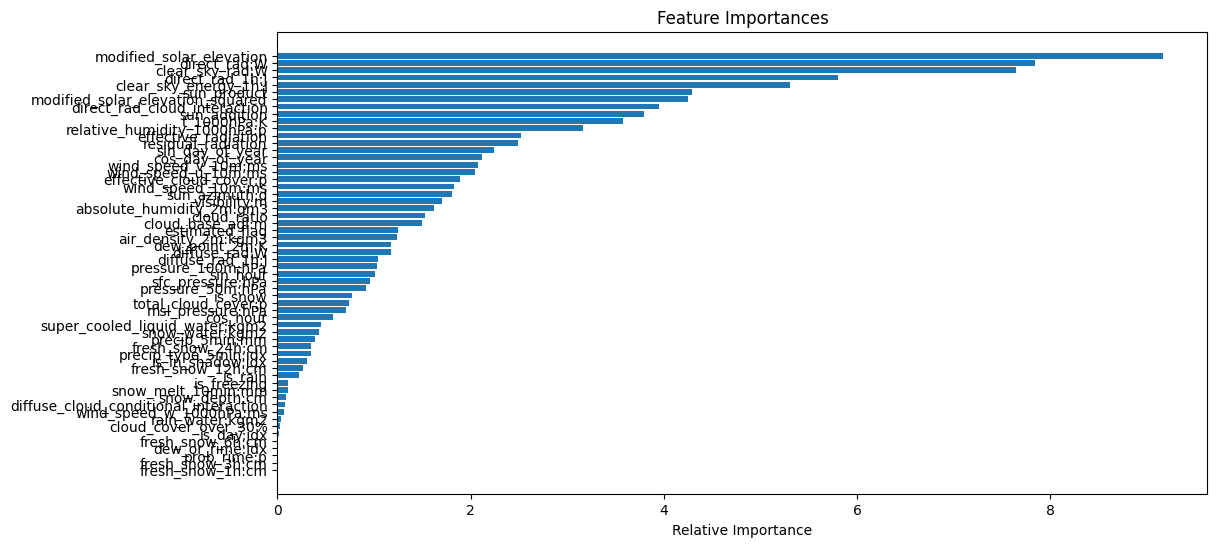

In [12]:
feature_importances = best_model_c.get_feature_importance()

# Get feature names
feature_names = x_whole_c.columns

# Create a pandas DataFrame to display importances
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# If you want to plot feature importances, you can use a bar chart:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

Postprocessing

In [13]:
import pandas as pd
import math

from src.features.preprocess_data import fetch_preprocessed_data

find_time_sin = lambda hour: math.sin(2 * math.pi * (hour) / 24)
find_time_cos = lambda hour: math.cos(2 * math.pi * (hour) / 24)

def postprocess_data(x_test: pd.DataFrame, y_pred: pd.DataFrame) -> pd.DataFrame:
    """Postprocess the data to set the predicted values to 0 at the correct times."""
    
    # Cap the min and max values for each location for each hour
    y_pred = cap_min_max_values(x_test, y_pred)

    # Set the predicted values to 0 at the correct times
    y_pred = set_0_pv_at_times(x_test, y_pred, "a", [22, 23, 0])
    y_pred = set_0_pv_at_times(x_test, y_pred, "b", [22, 23, 0])
    y_pred = set_0_pv_at_times(x_test, y_pred, "c", [22, 23, 0])

    return y_pred

def cap_min_max_values(x_test: pd.DataFrame, y_pred: pd.DataFrame) -> pd.DataFrame:
    """Cap the min and max values for each location for each hour."""
    for hour in range(24):
        # Get the min and max values for each location for each hour
        min_value_a, max_value_a = get_min_max_values_for_location_at_hour("a", hour)
        min_value_b, max_value_b = get_min_max_values_for_location_at_hour("b", hour)
        min_value_c, max_value_c = get_min_max_values_for_location_at_hour("c", hour)
        print(f"hour: {hour}, min_value_a: {min_value_a}, max_value_a: {max_value_a}, min_value_b: {min_value_b}, max_value_b: {max_value_b}, min_value_c: {min_value_c}, max_value_c: {max_value_c}")
        # Cap the values between min_value and max_value
        y_pred = cap_min_max_values_for_hour(x_test, y_pred, "a", hour, min_value_a, max_value_a)
        y_pred = cap_min_max_values_for_hour(x_test, y_pred, "b", hour, min_value_b, max_value_b)
        y_pred = cap_min_max_values_for_hour(x_test, y_pred, "c", hour, min_value_c, max_value_c)
    return y_pred

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data(drop_features=False)
x_whole_with_time = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])

def get_min_max_values_for_location_at_hour(location: str, hour: int) -> tuple[float, float]:
    """Get the min and max values for a specific location at a specific hour."""
    # Get the x and y for the given hour and location
    hour_sin = find_time_sin(hour)
    hour_cos = find_time_cos(hour)
    # find the min and max values for the given hour and location
    min_value = x_whole_with_time[(x_whole_with_time["location_" + location] == 1) & (x_whole_with_time["sin_hour"] == hour_sin) & (x_whole_with_time["cos_hour"] == hour_cos)]["pv_measurement"].min()
    max_value = x_whole_with_time[(x_whole_with_time["location_" + location] == 1) & (x_whole_with_time["sin_hour"] == hour_sin) & (x_whole_with_time["cos_hour"] == hour_cos)]["pv_measurement"].max()
    
    return (min_value, max_value)

def cap_min_max_values_for_hour(x_test: pd.DataFrame, y_pred: pd.DataFrame, location: str, hour: int, min_value: float, max_value: float) -> pd.DataFrame:
    """Cap the min and max values for a specific hour."""
    
    # Calculate sin and cos values for the given hour
    hour_sin = find_time_sin(hour)
    hour_cos = find_time_cos(hour)
    
    # Find indices corresponding to the given hour at the given location
    indices = x_test[(x_test["location_" + location] == 1) & (x_test["sin_hour"] == hour_sin) & (x_test["cos_hour"] == hour_cos)].index
    
    # Cap the values between min_value and max_value
    y_pred.loc[indices] = y_pred.loc[indices].clip(min_value, max_value)
    
    return y_pred

def set_0_pv_at_times(x_test: pd.DataFrame, y_pred: pd.DataFrame, location: str, hours: list[int]) -> pd.DataFrame:
    """Find the correct predicted values at the given times and locaiton and set them to 0."""
    hours_to_set_0_sin = [find_time_sin(hour) for hour in hours]
    hours_to_set_0_cos = [find_time_cos(hour) for hour in hours]


    indices = x_test[(x_test["location_" + location] == 1) & (x_test["sin_hour"].isin(hours_to_set_0_sin) & (x_test["cos_hour"].isin(hours_to_set_0_cos)))].index
    for index in indices:
        y_pred.loc[index] = 0
    return y_pred


## Final predictions

In [14]:
x_whole_a = x_test_whole[x_test_whole['location_a'] == 1]
x_whole_b = x_test_whole[x_test_whole['location_b'] == 1]
x_whole_c = x_test_whole[x_test_whole['location_c'] == 1]

x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [15]:
import pandas as pd

RES_PATH = 'results/output/'


def save_predictions(test: pd.DataFrame, filename: str) -> None:
    """
    Save the 'id' and 'prediction' columns of the test DataFrame to a CSV file.
    
    Parameters:
        test (pd.DataFrame): A 1D DataFrame containing only the predictions.
        filename (str): The name of the file where the predictions will be saved.
    """
    model = pd.DataFrame()
    
    model["prediction"] = test
    model['id'] = model.index

    model['prediction'] = model['prediction'].apply(lambda x: max(0, x))
    
    # Reorder the columns to ensure 'id' comes before 'prediction'
    model = model[['id', 'prediction']]
    

    # Save the resulting DataFrame to a CSV file
    model.to_csv(f'{RES_PATH}{filename}.csv', index=False)
    
    # Display the first few rows of the saved DataFrame
    print(model.head())

In [16]:
y_predictions_a = best_model_a.predict(x_whole_a)
y_predictions_b = best_model_b.predict(x_whole_b)
y_predictions_c = best_model_c.predict(x_whole_c)
y_predictions = pd.concat([pd.Series(y_predictions_a), pd.Series(y_predictions_b), pd.Series(y_predictions_c)])
y_predictions = y_predictions.reset_index(drop=True)
# Save the model
y_predictions_catboost_1 = postprocess_data(x_test_whole, pd.DataFrame(y_predictions))
save_predictions(y_predictions, 'catboost modified solar elevation squared')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_

Second catboost model with 

In [17]:
x_whole = x_whole.drop("modified_solar_elevation_squared", axis=1)
x_test_whole = x_test_whole.drop("modified_solar_elevation_squared", axis=1)

In [18]:
x_whole["pv_measurement"] = y_whole
df_shuffled = x_whole.sample(frac=1, random_state=42).reset_index(drop=True)

x_whole_a = df_shuffled[df_shuffled['location_a'] == 1]
x_whole_b = df_shuffled[df_shuffled['location_b'] == 1]
x_whole_c = df_shuffled[df_shuffled['location_c'] == 1]

y_whole_a = x_whole_a["pv_measurement"]
x_whole_a = x_whole_a.drop("pv_measurement", axis = 1)
x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

y_whole_b = x_whole_b["pv_measurement"]
x_whole_b = x_whole_b.drop("pv_measurement", axis = 1)
x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

y_whole_c = x_whole_c["pv_measurement"]
x_whole_c = x_whole_c.drop("pv_measurement", axis = 1)
x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)
cat_features = ["estimated_flag"]

In [19]:
best_model_a = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function="MAE",
    verbose = 100
)
best_model_a.fit(x_whole_a, y_whole_a)

0:	learn: 616.9363093	total: 43.3ms	remaining: 43.3s
100:	learn: 199.9656401	total: 4.11s	remaining: 36.6s
200:	learn: 185.3356686	total: 8.38s	remaining: 33.3s
300:	learn: 180.5070612	total: 12.8s	remaining: 29.7s
400:	learn: 176.7196537	total: 17.3s	remaining: 25.8s
500:	learn: 172.6197441	total: 21.7s	remaining: 21.6s
600:	learn: 163.7581476	total: 25.9s	remaining: 17.2s
700:	learn: 153.8238135	total: 30s	remaining: 12.8s
800:	learn: 147.6203702	total: 34.1s	remaining: 8.48s
900:	learn: 141.6572310	total: 38.7s	remaining: 4.25s
999:	learn: 136.7908527	total: 43.6s	remaining: 0us


In [20]:
best_model_b = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function = "MAE",
    verbose = 100
)
best_model_b.fit(x_whole_b, y_whole_b)

0:	learn: 94.1836286	total: 43.3ms	remaining: 43.3s
100:	learn: 25.3949714	total: 4.51s	remaining: 40.2s
200:	learn: 22.1209997	total: 8.98s	remaining: 35.7s
300:	learn: 20.7702607	total: 13.5s	remaining: 31.2s
400:	learn: 19.4111036	total: 18s	remaining: 26.8s
500:	learn: 18.1584056	total: 22.2s	remaining: 22.1s
600:	learn: 17.4038913	total: 26.3s	remaining: 17.5s
700:	learn: 16.7939747	total: 30.4s	remaining: 13s
800:	learn: 16.1720278	total: 34.6s	remaining: 8.58s
900:	learn: 15.6136213	total: 38.6s	remaining: 4.25s
999:	learn: 15.1423810	total: 42.7s	remaining: 0us


In [21]:
best_model_c = CatBoostRegressor(
    max_depth=9,
    cat_features=cat_features,
    loss_function = "MAE",
    verbose = 100
)
best_model_c.fit(x_whole_c, y_whole_c)

0:	learn: 78.7273693	total: 42.7ms	remaining: 42.7s
100:	learn: 21.3078061	total: 4.1s	remaining: 36.5s
200:	learn: 18.2258783	total: 8.19s	remaining: 32.5s
300:	learn: 17.0883950	total: 12.2s	remaining: 28.2s
400:	learn: 16.1611729	total: 16.2s	remaining: 24.2s
500:	learn: 15.2436549	total: 20.2s	remaining: 20.1s
600:	learn: 14.4853484	total: 24.2s	remaining: 16s
700:	learn: 13.7033024	total: 28.2s	remaining: 12s
800:	learn: 13.1848967	total: 32.2s	remaining: 8.01s
900:	learn: 12.7181220	total: 36.4s	remaining: 4s
999:	learn: 12.3918690	total: 40.3s	remaining: 0us


In [22]:
x_whole_a = x_test_whole[x_test_whole['location_a'] == 1]
x_whole_b = x_test_whole[x_test_whole['location_b'] == 1]
x_whole_c = x_test_whole[x_test_whole['location_c'] == 1]

x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [23]:
y_predictions_a = best_model_a.predict(x_whole_a)
y_predictions_b = best_model_b.predict(x_whole_b)
y_predictions_c = best_model_c.predict(x_whole_c)
y_predictions = pd.concat([pd.Series(y_predictions_a), pd.Series(y_predictions_b), pd.Series(y_predictions_c)])
y_predictions = y_predictions.reset_index(drop=True)


# Save the model
y_predictions_catboost_2 = postprocess_data(x_test_whole, pd.DataFrame(y_predictions))
save_predictions(y_predictions, 'catboost without modified solar elevation')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_

In [24]:
average_prediction = (y_predictions_catboost_1 + y_predictions_catboost_2) / 2
save_predictions(average_prediction, "catboost final")

   id    prediction
0   0  0.000000e+00
1   1  2.646294e-07
2   2  2.654392e-07
3   3  5.696562e+01
4   4  3.288108e+02
